## 4. modelling using constructed features

### 4.1 develop function for classification model development, evaluation and parameter optimization

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, plot_roc_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

In [35]:
#optimize the hyperparameters in classification algorithms
def classification_tune(clf_estimator, param_grid, X_train, y_train, X_test, y_test):
    ##find the best model
    clf_random = RandomizedSearchCV(estimator = clf_estimator, param_distributions=param_grid, cv = 5, verbose=2, random_state=42, n_jobs = -1)
    clf_random.fit(X_train, y_train)
    best_clf=clf_random.best_estimator_
    y_pred=best_clf.predict(X_test)
    y_pred_proba = best_clf.predict_proba(X_test_s)[::,1]
    print("BEST PARAMS", clf_random.best_params_)
    return best_clf, y_pred, y_pred_proba 

In [36]:
#evaluation of the classification models
def classification_eval(best_clf, y_test, y_pred, y_pred_proba):
    cnf_matrix = confusion_matrix(y_test, y_pred)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g', ax=ax1)
    plt.tight_layout()
    ax1.set_title('Confusion matrix')
    ax1.set_ylabel('Actual label')
    ax1.set_xlabel('Predicted label')
    print("Accuracy:",accuracy_score(y_test, y_pred).round(3))
    print("Precision:",precision_score(y_test, y_pred).round(3))
    print("Recall:", recall_score(y_test, y_pred).round(3))
    print("f1 score:", f1_score(y_test, y_pred).round(3))
    fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba).round(3)
    ax2.plot(fpr,tpr,label="data 1, auc="+str(auc))
    plt.legend(loc=4)
    return ax1, ax2 
    

In [37]:
#find the importance of features
def feature_importance(best_clf):
    fea_importance=dict(zip(features_name, np.round(best_clf.feature_importances_, 2)))
    sort_fea_importance={}
    sorted_keys = sorted(fea_importance, key=fea_importance.get)
    for i in sorted_keys:
        sort_fea_importance[i]=fea_importance[i]
    return sort_fea_importance

### 4.2 import df_sum related files

Q: Can we develop better model using df_sum instead of df_new??

In [38]:
file='data/df_sum.csv'
df=pd.read_csv(file)

In [39]:
features_name=df.drop(columns=['DEFAULT', 'ID']).columns
features_name

Index(['LIMIT_BAL', 'SEX_2', 'EDUCATION_2', 'EDUCATION_3', 'EDUCATION_4',
       'MARRIAGE_2', 'MARRIAGE_3', 'AGE', 'pay_sum', 'mean_utilization_ratio',
       'bill_trend', 'bill_sum', 'pay_trend', 'payment_sum',
       'mean_payment_ratio', '6_month_loss_given_default'],
      dtype='object')

In [40]:
from numpy import loadtxt
X_train_s = loadtxt('data/X2_train_s.csv', delimiter=',')
X_test_s = loadtxt('data/X2_test_s.csv', delimiter=',')
y_train = loadtxt('data/y2_train.csv', delimiter=',')
y_test = loadtxt('data/y2_test.csv', delimiter=',')

### 4.3 Model development
#### 4.3.1 Regularized logistic regression

In [41]:
param_grid = {'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100]}
clf_estimator = LogisticRegression()
best_clf, y_pred, y_pred_proba=classification_tune(clf_estimator, param_grid, X_train_s, y_train, X_test_s, y_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
BEST PARAMS {'C': 50}


Accuracy: 0.797
Precision: 0.672
Recall: 0.176
f1 score: 0.279


(<AxesSubplot:title={'center':'Confusion matrix'}, xlabel='Predicted label', ylabel='Actual label'>,
 <AxesSubplot:>)

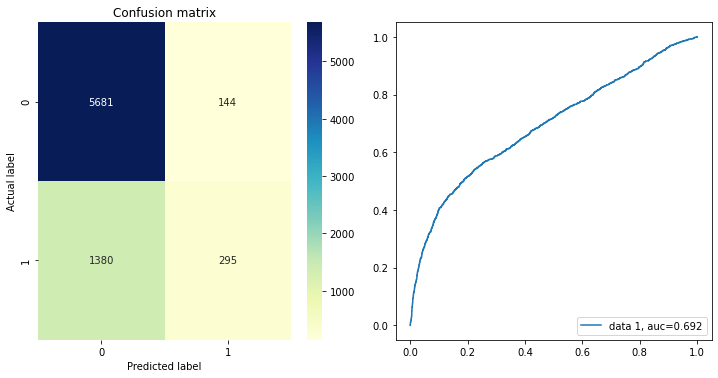

In [42]:
classification_eval(best_clf, y_test, y_pred, y_pred_proba)

In [43]:
from sklearn.feature_selection import SelectFromModel
sfm=SelectFromModel(best_clf, threshold=-np.inf, max_features=3)
sfm.fit(X_train_s, y_train)
feature_idx=sfm.get_support()
feature_name=features_name[feature_idx]
feature_name

Index(['LIMIT_BAL', 'pay_sum', 'payment_sum'], dtype='object')

In [44]:
lg_coef=best_clf.coef_[0]
for i,v in enumerate(lg_coef):
    print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: -0.18343
Feature: 1, Score: -0.04815
Feature: 2, Score: -0.06649
Feature: 3, Score: -0.04063
Feature: 4, Score: -0.17026
Feature: 5, Score: -0.08010
Feature: 6, Score: -0.01621
Feature: 7, Score: 0.04633
Feature: 8, Score: 0.69473
Feature: 9, Score: -0.11747
Feature: 10, Score: -0.05041
Feature: 11, Score: -0.02922
Feature: 12, Score: -0.16393
Feature: 13, Score: -0.44714
Feature: 14, Score: -0.01652
Feature: 15, Score: 0.04860


In [45]:
print(features_name[8], features_name[13], features_name[0])

pay_sum payment_sum LIMIT_BAL


pay_sum is far more important than the rest of the other features, as indicated by the high coefficent value, 0.69.

#### 4.3.2 Decision tree

In [46]:
from sklearn.tree import export_graphviz
import graphviz 
param_grid = {'criterion': ['gini', 'entropy'], 'max_depth':[2,4,6,8,10,12]}
clf_estimator = DecisionTreeClassifier()
best_clf, y_pred, y_pred_proba=classification_tune(clf_estimator, param_grid, X_train_s, y_train, X_test_s, y_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
BEST PARAMS {'max_depth': 4, 'criterion': 'entropy'}


Accuracy: 0.801
Precision: 0.625
Recall: 0.276
f1 score: 0.383


(<AxesSubplot:title={'center':'Confusion matrix'}, xlabel='Predicted label', ylabel='Actual label'>,
 <AxesSubplot:>)

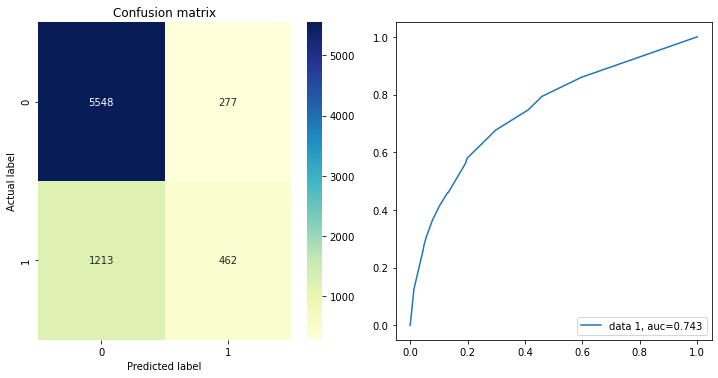

In [47]:
classification_eval(best_clf, y_test, y_pred, y_pred_proba)

In [48]:
feature_importance(best_clf)

{'SEX_2': 0.0,
 'EDUCATION_2': 0.0,
 'EDUCATION_3': 0.0,
 'EDUCATION_4': 0.0,
 'MARRIAGE_2': 0.0,
 'MARRIAGE_3': 0.0,
 'mean_utilization_ratio': 0.0,
 'bill_trend': 0.0,
 'pay_trend': 0.0,
 'mean_payment_ratio': 0.0,
 '6_month_loss_given_default': 0.0,
 'AGE': 0.01,
 'LIMIT_BAL': 0.03,
 'bill_sum': 0.04,
 'payment_sum': 0.11,
 'pay_sum': 0.81}

pay_sum is still the most important one. Its feature important score is much higher than the rest, 0.81.

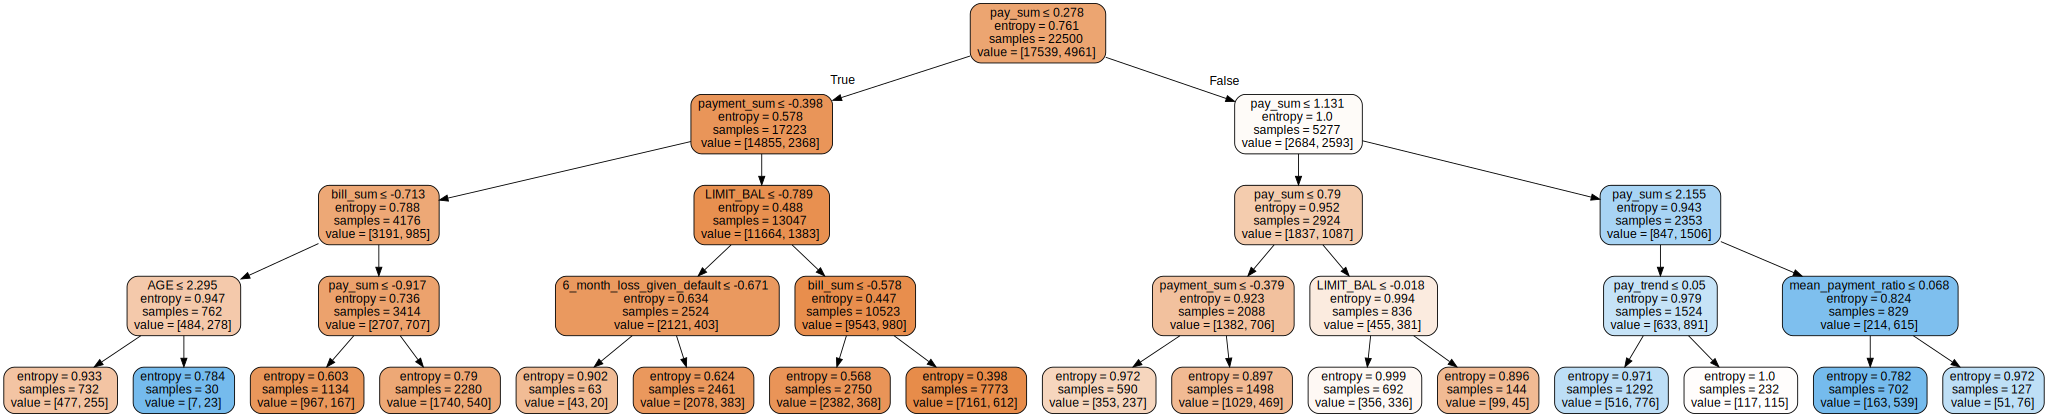

In [49]:
dot_data = export_graphviz(best_clf, out_file = None, feature_names = features_name, filled = True, rounded = True, special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

#### 4.3.3 Random forest

In [50]:
n_estimators=[int(x) for x in np.linspace(start = 50, stop = 500, num = 10)]
max_depths=[int(x) for x in np.linspace(1, 10, num = 10)]
param_grid = {'n_estimators': n_estimators, 'max_depth':max_depths}
clf_estimator = RandomForestClassifier()
best_clf, y_pred, y_pred_proba=classification_tune(clf_estimator, param_grid, X_train_s, y_train, X_test_s, y_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
BEST PARAMS {'n_estimators': 200, 'max_depth': 9}


Accuracy: 0.8
Precision: 0.607
Recall: 0.296
f1 score: 0.398


(<AxesSubplot:title={'center':'Confusion matrix'}, xlabel='Predicted label', ylabel='Actual label'>,
 <AxesSubplot:>)

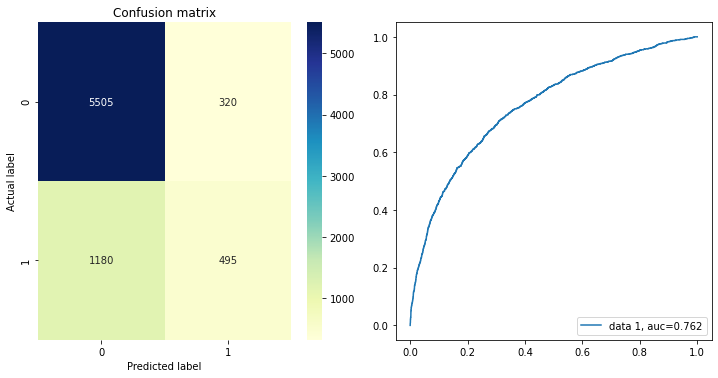

In [51]:
classification_eval(best_clf, y_test, y_pred, y_pred_proba)

In [52]:
feature_importance(best_clf)

{'SEX_2': 0.0,
 'EDUCATION_2': 0.0,
 'EDUCATION_3': 0.0,
 'EDUCATION_4': 0.0,
 'MARRIAGE_3': 0.0,
 'MARRIAGE_2': 0.01,
 'AGE': 0.04,
 'bill_sum': 0.05,
 'pay_trend': 0.05,
 'mean_payment_ratio': 0.05,
 '6_month_loss_given_default': 0.05,
 'LIMIT_BAL': 0.06,
 'mean_utilization_ratio': 0.07,
 'bill_trend': 0.07,
 'payment_sum': 0.09,
 'pay_sum': 0.45}

The same story for pay_sum repeated in random forest. 

#### 4.3.4 Gradient boosting

In [53]:
n_estimators=[int(x) for x in np.linspace(start = 50, stop = 500, num = 10)]
max_depths=[int(x) for x in np.linspace(1, 10, num = 10)]
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
param_grid = {'n_estimators': n_estimators, 'max_depth':max_depths, 'learning_rate': learning_rates}
clf_estimator = GradientBoostingClassifier()
best_clf, y_pred, y_pred_proba=classification_tune(clf_estimator, param_grid, X_train_s, y_train, X_test_s, y_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
BEST PARAMS {'n_estimators': 50, 'max_depth': 2, 'learning_rate': 0.1}


Accuracy: 0.802
Precision: 0.616
Recall: 0.299
f1 score: 0.402


(<AxesSubplot:title={'center':'Confusion matrix'}, xlabel='Predicted label', ylabel='Actual label'>,
 <AxesSubplot:>)

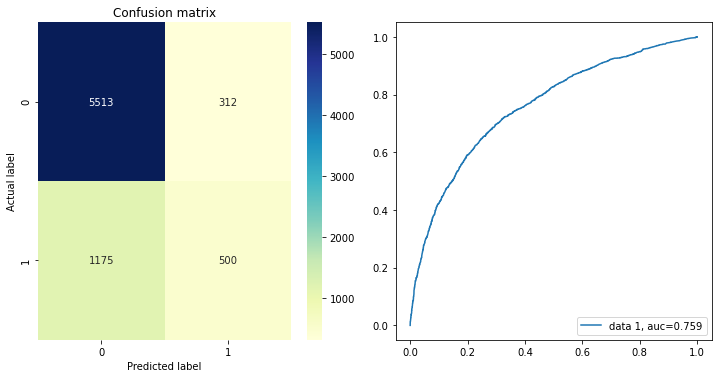

In [54]:
classification_eval(best_clf, y_test, y_pred, y_pred_proba)

In [55]:
feature_importance(best_clf)

{'SEX_2': 0.0,
 'EDUCATION_2': 0.0,
 'EDUCATION_3': 0.0,
 'EDUCATION_4': 0.0,
 'MARRIAGE_2': 0.0,
 'MARRIAGE_3': 0.0,
 'AGE': 0.0,
 '6_month_loss_given_default': 0.0,
 'mean_utilization_ratio': 0.01,
 'bill_trend': 0.01,
 'pay_trend': 0.01,
 'mean_payment_ratio': 0.01,
 'LIMIT_BAL': 0.02,
 'bill_sum': 0.05,
 'payment_sum': 0.07,
 'pay_sum': 0.83}

pay_sum is the winner again.

#### 4.3.5 Extreme Gradient Boosting (XGBoost)

In [56]:
reg_alphas=[0, 0.001, 0.005, 0.01, 0.05]
gammas=[0.1, 0.2, 0.3, 0.4, 0.5]
subsamples=[0.5, 0.6, 0.7, 0.8]
n_estimators=[int(x) for x in np.linspace(start = 50, stop = 500, num = 10)]
max_depths=[int(x) for x in np.linspace(1, 10, num = 10)]
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
param_grid = {'reg_alpha':reg_alphas,'gamma':gammas, 'subsample': subsamples, 'n_estimators': n_estimators, 'max_depth':max_depths, 'learning_rate': learning_rates}
clf_estimator=XGBClassifier(use_label_encoder=False)
best_clf, y_pred, y_pred_proba=classification_tune(clf_estimator, param_grid, X_train_s, y_train, X_test_s, y_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[01:41:28] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
BEST PARAMS {'subsample': 0.7, 'reg_alpha': 0.05, 'n_estimators': 400, 'max_depth': 1, 'learning_rate': 0.1, 'gamma': 0.4}


Accuracy: 0.803
Precision: 0.614
Recall: 0.322
f1 score: 0.422


(<AxesSubplot:title={'center':'Confusion matrix'}, xlabel='Predicted label', ylabel='Actual label'>,
 <AxesSubplot:>)

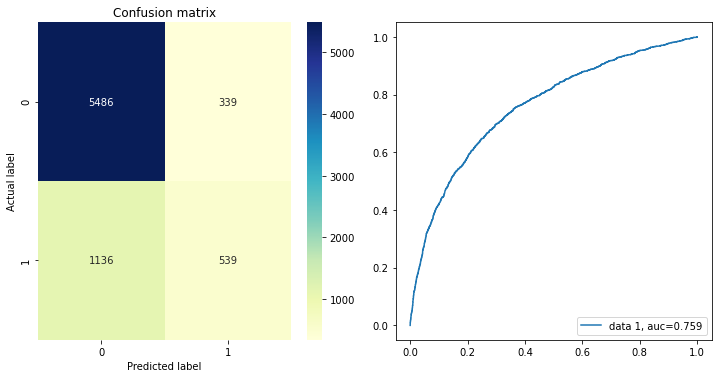

In [57]:
classification_eval(best_clf, y_test, y_pred, y_pred_proba)

In [58]:
feature_importance(best_clf)

{'EDUCATION_2': 0.0,
 'EDUCATION_3': 0.0,
 'MARRIAGE_3': 0.0,
 'SEX_2': 0.03,
 'MARRIAGE_2': 0.03,
 'AGE': 0.03,
 'bill_trend': 0.03,
 'pay_trend': 0.03,
 '6_month_loss_given_default': 0.03,
 'EDUCATION_4': 0.04,
 'mean_payment_ratio': 0.04,
 'mean_utilization_ratio': 0.05,
 'LIMIT_BAL': 0.06,
 'bill_sum': 0.06,
 'payment_sum': 0.15,
 'pay_sum': 0.41}

#### 4.3.6 KNN

In [59]:
n_neighbors = [50, 100, 500, 1000, 5000]
p=[1,2]
param_grid ={'n_neighbors':n_neighbors, 'p':p}
clf_estimator=KNeighborsClassifier()
best_clf, y_pred, y_pred_proba=classification_tune(clf_estimator, param_grid, X_train_s, y_train, X_test_s, y_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
BEST PARAMS {'p': 2, 'n_neighbors': 50}


Accuracy: 0.796
Precision: 0.636
Recall: 0.204
f1 score: 0.309


(<AxesSubplot:title={'center':'Confusion matrix'}, xlabel='Predicted label', ylabel='Actual label'>,
 <AxesSubplot:>)

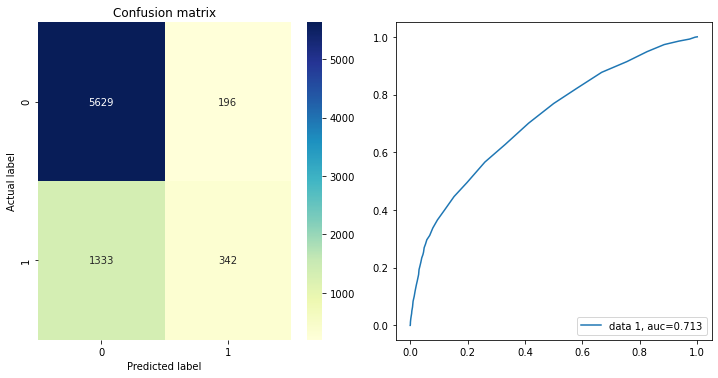

In [60]:
classification_eval(best_clf, y_test, y_pred, y_pred_proba)

In [61]:
from sklearn.model_selection import cross_val_score
n_feats = X_train_s.shape[1]
print('Feature  Accuracy')
for i in range(n_feats):
    X = X_train_s[:, i].reshape(-1, 1)
    scores = cross_val_score(best_clf, X, y_train, cv=5)
    print(f'{i}        {scores.mean():g}')

Feature  Accuracy
0        0.779511
1        0.779511
2        0.779511
3        0.779511
4        0.779511
5        0.779511
6        0.779511
7        0.779511
8        0.806356
9        0.779511
10        0.777956
11        0.779378
12        0.779467
13        0.779556
14        0.779511
15        0.779289


In [62]:
print(features_name[8], features_name[13])

pay_sum payment_sum


### 4.4 summary

1. We get pretty comparable model results using the smaller data set, df_sum, with our engineered features
2. XGBoost gave us the best model with AUC value 0.759 and f1 score 0.422, followed by random forest and gradient boosting, and then the other more traditional algorithms.
3. The most critical feature in these models is pay_sum. As a matter of fact, it is far more important than the rest of the features in df_sum data set regardless of which algorithm we applied. It is an index to show the accumulated payment behavior, on time, or delay. Besides pay_sum, payment_sum, bill_sum, limit_bal are also listed as the most critical features in most of the algorithms. Generally speaking, transaction-related data showed more contribution in these models than socioeconomic features.